# Gibbs采样的Python实现
Gibbs采样是一种用于从高维概率分布中生成样本的马尔可夫链蒙特卡罗（MCMC）方法。它通过依次从每个变量  
的条件分布中采样，构建一个以目标分布为平稳分布的马尔可夫链。以下将使用Python实现Gibbs采样，  
从一个二维高斯分布中生成样本。

### 目标分布

我们考虑一个二维正态分布，其联合概率密度函数为：

$$
p(x, y) = N\left( 
\begin{bmatrix}
\mu_x \\
\mu_y
\end{bmatrix}
, 
\begin{bmatrix}
\sigma_x^2 & \rho \sigma_x \sigma_y \\
\rho \sigma_x \sigma_y & \sigma_y^2
\end{bmatrix}
\right)
$$

其中：

- $\mu_x$ 和 $\mu_y$ 是均值
- $\sigma_x$ 和 $\sigma_y$ 是标准差
- $\rho$ 是相关系数，取值范围为 $[-1, 1]$


### 条件分布

对于多元正态分布，其条件分布仍然是正态分布：

**给定 $y$，$x$ 的条件分布为**：

$$
p(x \mid y) = N\left(\mu_{x \mid y}, \sigma_{x \mid y}^2\right)
$$

其中：

$$
\mu_{x \mid y} = \mu_x + \rho \frac{\sigma_x}{\sigma_y} (y - \mu_y)
$$

$$
\sigma_{x \mid y}^2 = (1 - \rho^2) \sigma_x^2
$$

**给定 $x$，$y$ 的条件分布为**：

$$
p(y \mid x) = N\left(\mu_{y \mid x}, \sigma_{y \mid x}^2\right)
$$

其中：

$$
\mu_{y \mid x} = \mu_y + \rho \frac{\sigma_y}{\sigma_x} (x - \mu_x)
$$

$$
\sigma_{y \mid x}^2 = (1 - \rho^2) \sigma_y^2
$$

## 代码实现  
### 参数设置

- **均值和标准差**：  
  我们将 $\mu_x$、$\mu_y$ 设为 0，$\sigma_x$、$\sigma_y$ 设为 1。

- **相关系数**：  
  $\rho$ 设为 0.8，表示两个变量之间存在较强的正相关。

- **条件标准差**：  
  根据公式计算 $\sigma_{x \mid y}$ 和 $\sigma_{y \mid x}$，用于条件采样：

  $$
  \sigma_{x \mid y} = \sqrt{1 - \rho^2} \cdot \sigma_x
  $$

  $$
  \sigma_{y \mid x} = \sqrt{1 - \rho^2} \cdot \sigma_y
  $$


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 设置参数
mu_x = 0
mu_y = 0
sigma_x = 1
sigma_y = 1
rho = 0.8  # 相关系数

# 计算条件分布的标准差
sigma_x_given_y = np.sqrt(1 - rho**2) * sigma_x
sigma_y_given_x = np.sqrt(1 - rho**2) * sigma_y

# 迭代次数
num_samples = 10000
burn_in = 1000  # Burn-in期的样本数量

### 初始化

- **样本数组**：  
  创建大小为 `num_samples` 的数组 `x` 和 `y`，用于存储采样结果。

- **初始值**：  
  从各自的边缘分布中随机采样初始值。


In [2]:
# 初始化数组
x = np.zeros(num_samples)
y = np.zeros(num_samples)

# 初始值
x[0] = np.random.normal(mu_x, sigma_x)
y[0] = np.random.normal(mu_y, sigma_y)


### Gibbs 采样过程

**循环迭代**：对于每个样本：

1. **采样 $x$**：  
   给定当前的 $y$，根据条件分布采样新的 $x$。其中，计算条件均值 $\mu_{x \mid y}$：

   $$
   \mu_{x \mid y} = \mu_x + \rho \frac{\sigma_x}{\sigma_y} \left( y^{(i-1)} - \mu_y \right)
   $$

2. **采样 $y$**：  
   给定新的 $x$，根据条件分布采样新的 $y$。其中，计算条件均值 $\mu_{y \mid x}$：

   $$
   \mu_{y \mid x} = \mu_y + \rho \frac{\sigma_y}{\sigma_x} \left( x^{(i)} - \mu_x \right)
   $$


In [3]:
# Gibbs采样过程
for i in range(1, num_samples):
    # 给定 y[i-1]，采样 x[i]
    mu_x_given_y = mu_x + rho * (sigma_x / sigma_y) * (y[i-1] - mu_y)
    x[i] = np.random.normal(mu_x_given_y, sigma_x_given_y)
    
    # 给定 x[i]，采样 y[i]
    mu_y_given_x = mu_y + rho * (sigma_y / sigma_x) * (x[i] - mu_x)
    y[i] = np.random.normal(mu_y_given_x, sigma_y_given_x)

### 丢弃 Burn-in 期样本

- **Burn-in 期**：  
  为了确保马尔可夫链已达到平稳状态，通常会丢弃前 `burn_in` 个样本。
  

In [4]:
# 丢弃Burn-in期的样本
x = x[burn_in:]
y = y[burn_in:]

## 绘制结果

- **散点图**：  
  展示采样得到的 $(x, y)$ 点的分布，应接近于目标二维高斯分布。

- **轨迹图**：  
  展示前500个样本的变化轨迹，可以观察马尔可夫链的收敛和采样过程。


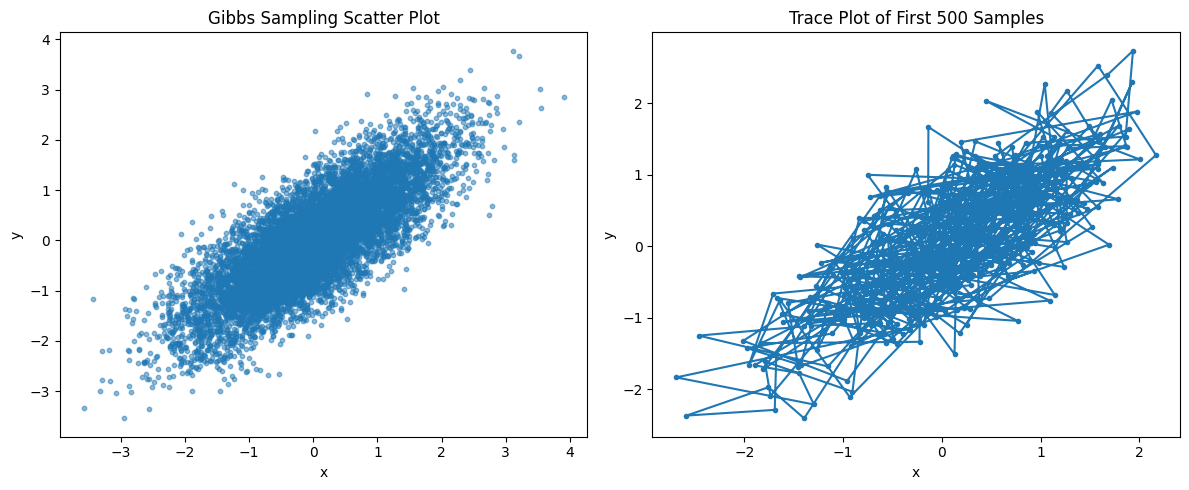

In [5]:
# 绘制结果
plt.figure(figsize=(12, 5))

# 子图1：散点图
plt.subplot(1, 2, 1)
plt.scatter(x, y, alpha=0.5, s=10)
plt.title('Gibbs Sampling Scatter Plot')
plt.xlabel('x')
plt.ylabel('y')

# 子图2：轨迹图（前500个样本）
plt.subplot(1, 2, 2)
plt.plot(x[:500], y[:500], '-o', markersize=3)
plt.title('Trace Plot of First 500 Samples')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()

## 运行结果

- **散点图**：  
  应显示出椭圆形的点云，反映出两个变量之间的正相关关系，符合目标分布的特性。

- **轨迹图**：  
  展示了采样点在二维空间中的移动路径，可以看到在初始阶段样本如何逐渐逼近目标分布的高密度区域。

## 注意事项

- **Burn-in 期的选择**：  
  Burn-in 期的长度取决于马尔可夫链的混合速度，通常需要根据具体问题和实验结果进行调整。

- **自相关性**：  
  Gibbs 采样生成的样本序列可能存在自相关性，影响统计估计的效率。可以通过增加总样本数量或只使用每隔一定步数的样本来减小影响。

- **高维扩展**：  
  对于更高维度的分布，Gibbs 采样依次更新每个变量即可，但计算条件分布可能变得复杂，需要确保条件分布易于采样。
